In [1]:
# General imports
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as ssd
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score

# Custom imports
from modules import RC_model

# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)

First, we define the hyperparameters of the RC model, which define:
- the Reservoir
- the dimensionality reduction procedure
- the MTS representation

**Important:** since now we are doing clustering, we set ``readout_type = None`` and do not specify the other readout hyperparameters. As we will see later, by setting ``readout_type = None`` the RC model will store the input representations, which will be accessed to compute our clusters.

In [2]:
config = {}

# Reservoir
config['n_internal_units'] = 450        # size of the reservoir
config['spectral_radius'] = 0.59        # largest eigenvalue of the reservoir
config['leak'] = 0.6                    # amount of leakage in the reservoir state update (None or 1.0 --> no leakage)
config['connectivity'] = 0.25           # percentage of nonzero connections in the reservoir
config['input_scaling'] = 0.1           # scaling of the input weights
config['noise_level'] = 0.01            # noise in the reservoir state update
config['n_drop'] = 5                    # transient states to be dropped
config['bidir'] = True                  # if True, use bidirectional reservoir
config['circ'] = False                  # use reservoir with circle topology

# Dimensionality reduction
config['dimred_method'] ='tenpca'       # options: {None (no dimensionality reduction), 'pca', 'tenpca'}
config['n_dim'] = 75                    # number of resulting dimensions after the dimensionality reduction procedure

# MTS representation
config['mts_rep'] = 'reservoir'         # MTS representation:  {'last', 'mean', 'output', 'reservoir'}
config['w_ridge_embedding'] = 10.0      # regularization parameter of the ridge regression

# Readout
config['readout_type'] = None           # by setting None, the input representations will be stored

Next we load the data. How to load the data depends on how your data are stored. In most cases, you will use the Pandas library. In this example, we use Multivariate Time Series (MTS) data stored in a ``.mat`` file that can be loaded with the Scipy library.

When we do classification, we need a training set to fit the parameters of the RC classifier and a validation/test set to test the classifier performance on new data. Instead, when doing colustering we just look at some structure in the data and we do not need the train/test split.

The RC model accepts data represented by a 3-dimensional array of shape $[N,T,V]$, where $N$ is the number of MTS, $T$ is the number of time steps in each MTS, and $V$ is the number of variables in each MTS.

**Important:** we assume the number of time steps $T$ to be the same for each of the $N$ MTS. If the MTS have different length, you can use zero-padding or other interpolation techniques to obtain the same length.

In this example, we have 640 MTS with 29 time steps and 12 variables.

In [3]:
dataset_name = 'JpVow'
data = scipy.io.loadmat('../dataset/'+dataset_name+'.mat')
X = data['X']  # shape is [N,T,V]
if len(X.shape) < 3:
    X = np.atleast_3d(X)
Y = data['Y']  # shape is [N,1]
Xte = data['Xte']
if len(Xte.shape) < 3:
    Xte = np.atleast_3d(Xte)
Yte = data['Yte']

# Since we are doing clustering, we do not need the train/test split
X = np.concatenate((X, Xte), axis=0)
Y = np.concatenate((Y, Yte), axis=0)

print('Loaded '+dataset_name+' - data shape: '+ str(X.shape))

Loaded JpVow - data shape: (640, 29, 12)


Now we can initialize our RC model with the hyperparameters specified above.

By calling ``.train(X)`` we generate the vectorial representations of the MTS contained in ``X``. These representations can be accessed from the ``.input_repr`` attribute.

In [4]:
# Initialize the RC model
rcm =  RC_model(
                reservoir=None,     
                n_internal_units=config['n_internal_units'],
                spectral_radius=config['spectral_radius'],
                leak=config['leak'],
                connectivity=config['connectivity'],
                input_scaling=config['input_scaling'],
                noise_level=config['noise_level'],
                circle=config['circ'],
                n_drop=config['n_drop'],
                bidir=config['bidir'],
                dimred_method=config['dimred_method'], 
                n_dim=config['n_dim'],
                mts_rep=config['mts_rep'],
                w_ridge_embedding=config['w_ridge_embedding'],
                readout_type=config['readout_type'] 
                )

# Generate representations of the input MTS
training_time = rcm.train(X)
mts_representations = rcm.input_repr
print("Training time: %.2f seconds"%training_time)

Training time: 0.04 seconds


Once obtained the MTS representations we can compute an $N \times N$ similarity matrix. Since the MTS representations are vectors, we can use any similarity measure for vectors. Here we use the cosine similarity and then normalize the similarity values in $[0,1]$.



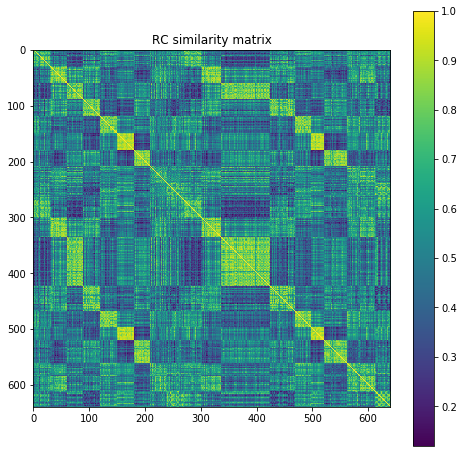

In [5]:
# Compute a similarity matrix from the cosine similarity of the representations
similarity_matrix = cosine_similarity(mts_representations)
        
# Normalize the similarity in [0,1]
similarity_matrix = (similarity_matrix + 1.0)/2.0

# Plot similarity matrix
fig =  plt.figure(figsize=(8,8))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()

As a sanity check and to see if the similarity matrix makes sense, we can sort the rows and columns according to the class labels. We should now see a block-structure, indicating that MTS of the same class are highly similar to each other and less similar to the MTS of other classes.

Note that the classes are imbalanced, *i.e.*, some classes (*e.g.*, class 3) are more populated than others.

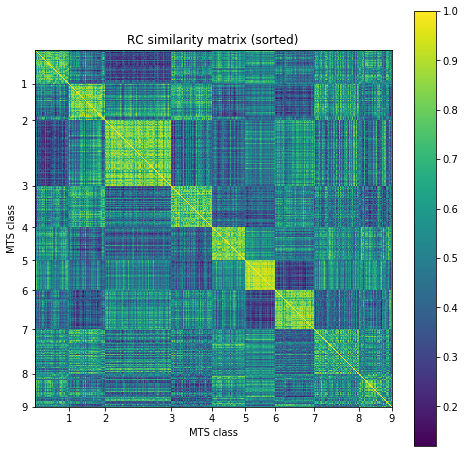

In [6]:
idx_sorted = np.argsort(Y[:,0])
similarity_sorted = similarity_matrix[:,idx_sorted][idx_sorted,:]
fig =  plt.figure(figsize=(8,8))
h = plt.imshow(similarity_sorted)
plt.title("RC similarity matrix (sorted)")
plt.colorbar(h)
class_num, _ = np.histogram(Y[:,0], bins=len(np.unique(Y)))
pos = np.cumsum(class_num)
plt.xticks(pos, np.unique(Y))
plt.yticks(pos, np.unique(Y))
plt.xlabel("MTS class")
plt.ylabel("MTS class")
plt.show()

As a second sanity check, we can see how the MTS look like in two dimensions, according to the similarity matrix we just computed.
For this purpose, we will use the Kernel PCA algorithm.

We can see that MTS of the same class end up close, confirming that the similarity between MTS in the same class is high.

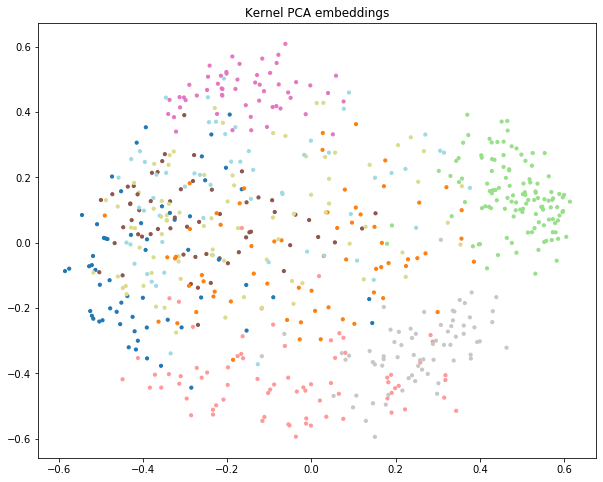

In [7]:
# Dimensionality reduction with Kernel PCA
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(similarity_matrix)
fig =  plt.figure(figsize=(10,8))
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y[:,0], s=10, cmap='tab20')
plt.title("Kernel PCA embeddings")
plt.show()

Finally, let's generate our actual clusters. Most clustering algorithm require a *distance* (or *dissimilarity*) matrix.
We can compute it from our similarity matrix as follows.

Note the diagonal must be zero because the dissimilarity of an element with itself is zero by definition. For small numerical errors, some element in the diagonal might not be exactly zero. Therefore, we force it.

In [8]:
# Compute Dissimilarity matrix
Dist = 1.0 - similarity_matrix
np.fill_diagonal(Dist, 0) # due to numerical errors, the diagonal might not be 0

There is a pletora of clustering algorithm that can be used at this point. The Sklearn library gives you a good range of choices [here](https://scikit-learn.org/stable/modules/clustering.html).

Since we know that our MTS are partitioned in 9 classes, we could cheat a bit (note that the class information should not be exploited when doing clustering) and use an algorithm such as *k-means* with 9 clusters.

However, in the following we rather use a hierarchical clustering algorithm that provides us with a nice visualization tool (the dendrogram) that allows us to explore and understand better the structure in our dataset.
The number of clusters in the hierarchical algorithm can be obtained by setting a threshold. This threshold should be decided by looking at the dendrogram, so that tall branches are cut.
By setting the threshold to ``t=2.0`` we obtain the 9 clusters that we are expecting.

In [9]:
# Hierarchical clustering
distArray = ssd.squareform(Dist)
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t=2.0, criterion="distance")
print("Found %d clusters"%len(np.unique(clust)))

Found 9 clusters


Usually there is not a clear way to evaluate the performance of a clustering results.
However if class labels are available (like in our case) we can compute the agreement between the class and the cluster labels.

There are several metrics to do that. One the is *Normalized Mutual Information* (which is equivalent to *v-score* when using a particular averaging function), which evaluates how homogeneous are the class labels of the elements in each cluster. 
NMI return a value in $[0,1]$ and the higher the better.
So, in this case, we are doing pretty well.

In [10]:
# Evaluate the agreement between class and cluster labels
nmi = v_measure_score(Y[:,0], clust)
print("Normalized Mutual Information (v-score): %.3f"%nmi)

Normalized Mutual Information (v-score): 0.889


Finally, let's plot the dendrogram (this might take a while...) and color the branches according to the threshold ``2.0``. 
Indeed, with the threshold ``2.0`` we are cutting long branches, that indicate there is a clear 9-clusters structure in our dataset.

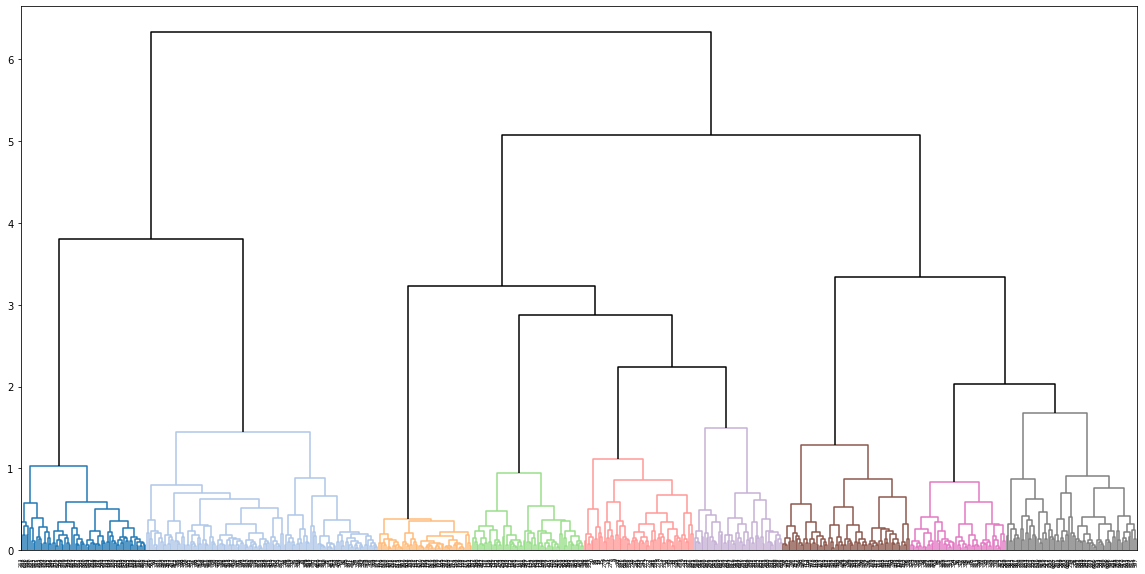

N. clusters:  9


In [11]:
# Plot dendrogram
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=2.0, labels=None, above_threshold_color='k')
plt.show()
print("N. clusters: ", np.unique(dn['color_list']).shape[0]-1)

By looking at the dendrogram, we notice that there is also a clear division in 3 clusters in our dataset.
We can obtain such a corarser partition by rising the threshold to ``4.5``.

There is not such a thing as *optimal number of clusters* and, thus, *optimal threshold value*. It boils down to the level of resolution you want to look at your data.

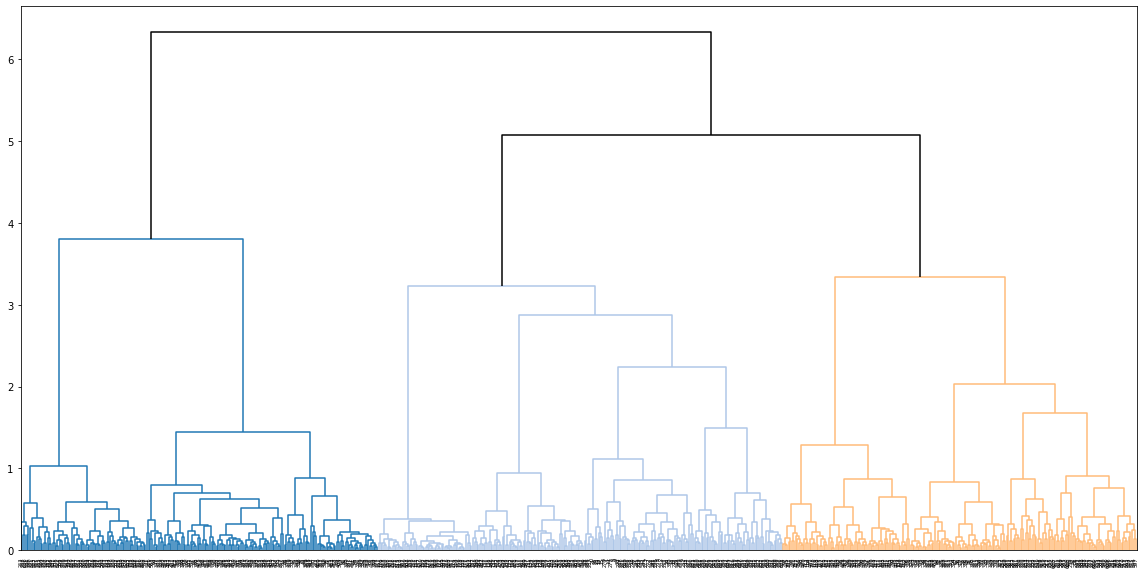

N. clusters:  3


In [12]:
# Plot dendrogram
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=4.5, labels=None, above_threshold_color='k')
plt.show()
print("N. clusters: ", np.unique(dn['color_list']).shape[0]-1)